### Import necessary libraries

In [7]:
import os
import io
import sys
import cv2
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from PIL import Image
from tqdm.auto import tqdm
sys.path.append('../..')
from definitions import DATA_DIR

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Reproducibility

In [304]:
SEED = 3
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Paths

In [205]:
train_images_path = os.path.join(DATA_DIR, 'train-image.hdf5')
train_meta_path = os.path.join(DATA_DIR, 'train-metadata.csv')
test_images_path = os.path.join(DATA_DIR, 'test-image.hdf5')
test_meta_path = os.path.join(DATA_DIR, 'test-metadata.csv')

### Data loading

In [206]:
train_metadata = pd.read_csv(train_meta_path)

### Utils

In [207]:
def load_images(ids):
    images = []
    for id in ids:
        img = cv2.imread(f'{DATA_DIR}/train-image/image/{id}.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

In [208]:
def show_images(images, labels=None):
    _, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, ax) in enumerate(zip(images, axs)):
        ax.imshow(img)
        ax.axis('off')
        if labels:
            ax.set_title(labels[i])
    plt.show()

In [308]:
def hair_remove(images):
    final_images = []

    for image in images:
        # convert image to grayScale
        grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # kernel for morphologyEx
        kernel = np.ones((10, 10), np.uint8)
        
        # apply MORPH_BLACKHAT to grayScale image
        blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

        # apply thresholding to blackhat
        _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
        # inpaint with original image and threshold image
        final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
        
        final_images.append(final_image)

    return final_images

In [309]:
def unsharp_mask(images, original_images, alpha=1.5, beta=-0.5, gamma=0, sigma=10):
    final_images = []

    for image, original in zip(images, original_images):
        # Apply gaussian blur
        gaussian_3 = cv2.GaussianBlur(image, (image.shape[0], image.shape[1]), sigma)

        # Apply unsharp mask
        unsharp_image = cv2.addWeighted(image, alpha, gaussian_3, beta, gamma, original)
        
        final_images.append(unsharp_image)

    return final_images

### Preprocessing

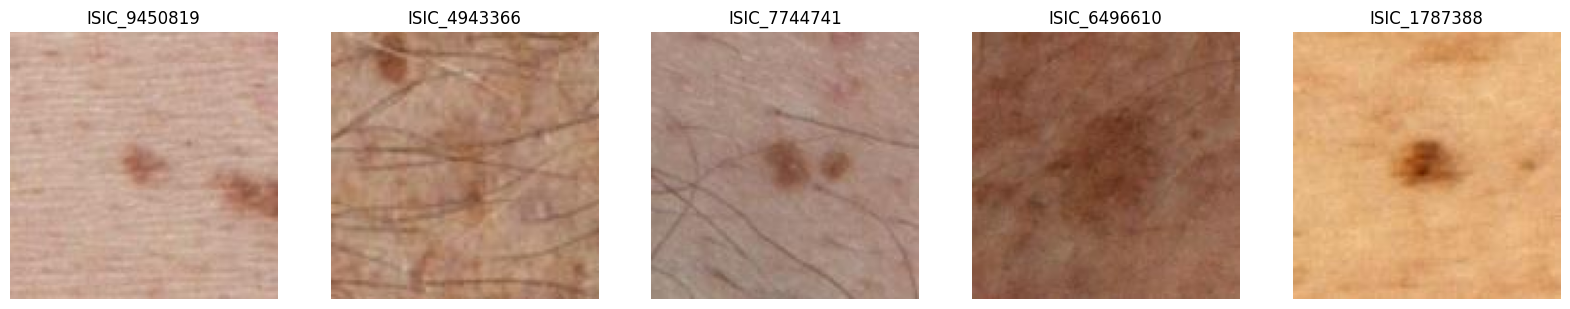

In [310]:
images_ids = train_metadata['isic_id'].sample(5, random_state=SEED).values.tolist()
images = load_images(images_ids)
show_images(images, images_ids)

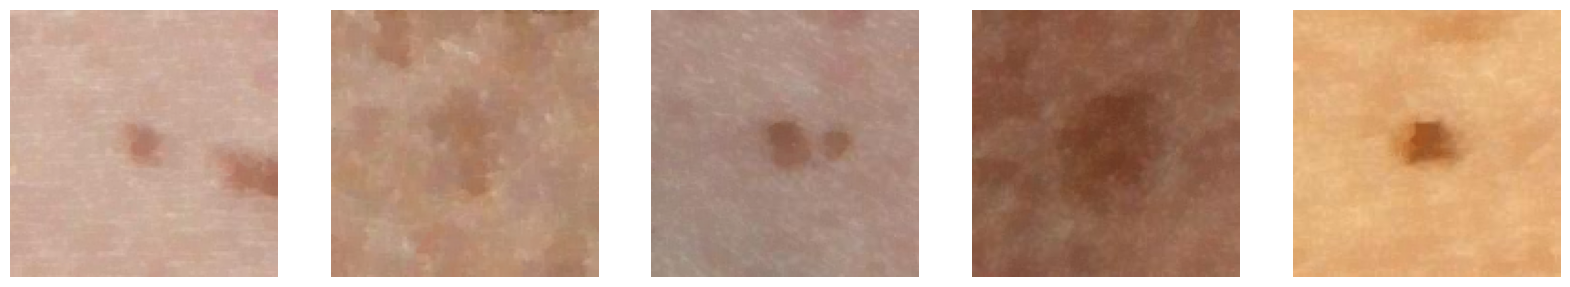

In [311]:
unhaired_images = hair_remove(images)
show_images(unhaired_images)

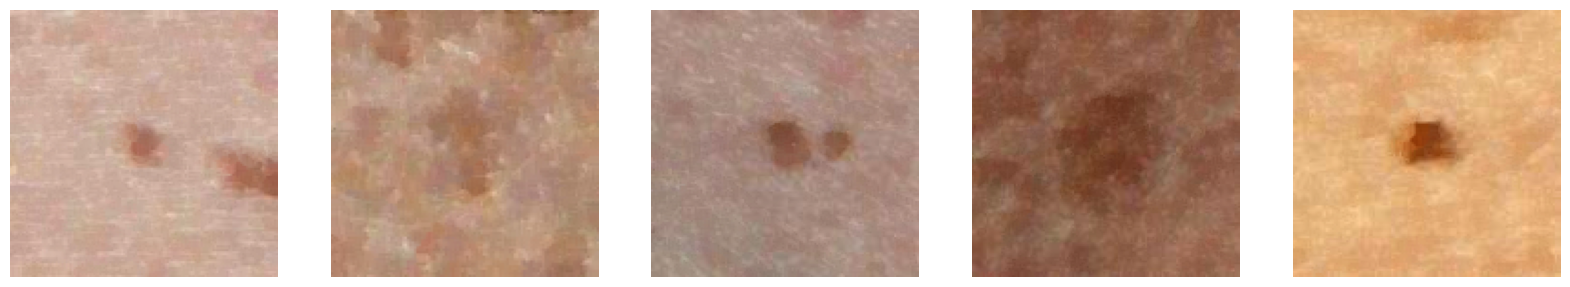

In [312]:
unsharp_images = unsharp_mask(unhaired_images, images)
show_images(unsharp_images)